**Instructions + Ratings**
- rows (int)
- exact_dup_rate (float)
- token_p95_est (int)
- category_counts (dict: {category -> int})
- avg_response_length_by_rating (dict: {1..5 -> float})
- empty_high_rating_count (int)

# Pack: instructions
- Instruction/response JSON with `source`, `category`, `rating`.
- Injected duplicates, label noise (empty high-rating), and long responses.
## Closed-ended tasks
1) Exact duplicate rate.
2) p95 token length; share of tokens in top 5% (optional).
3) Category distribution; avg response length by rating (spot length bias).
4) Count of empty responses with rating >=4; propose filters + retention.


In [10]:
from pathlib import Path

files = list(Path("./").glob("instr*json*"))
files[15]

PosixPath('instr_0397.json.gz')

In [31]:
import pandas as pd

dfs = []
for file in files:
    try:
        df = pd.read_json(file, lines=False)
    except Exception:
        df = pd.read_json(file, lines=True)
    df['_row'] = df.index
    df['_file'] = str(file)
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)
df

,id,source,category,instruction,response,rating,_pair_hash,_row,_file
0,i708_0,synth_prompted,history,step please help thanks please help windows pl...,the explain use please data configure configur...,4,a7748aaf18855bd01d43c894a45fd29d,0,instr_0708.json
1,i708_1,wiki_how,history,configure guide windows lazy fox data over tha...,how example how linux linux thanks thanks use ...,5,99787fe4672c0d5aa3ced722230ca46c,1,instr_0708.json
2,i358_0,wiki_how,finance,help install windows jumps linux function api ...,please configure data dog explain example dog ...,2,cdb1e56704819ca91fb18526f04f734c,0,instr_0358.json
3,i358_1,wiki_how,science,help thanks please example jumps explain ubunt...,please jumps brown dog fox guide to install ex...,3,73f76e528cea89e171e6488801bec22c,1,instr_0358.json
4,i358_2,wiki_how,math,over function use how please api configure ubu...,brown linux to to fox guide the api fox thanks...,5,40ac991e87f899c80570d957bdf989b7,2,instr_0358.json
...,...,...,...,...,...,...,...,...,...
2494,i9_1,synth_prompted,writing,quick fox explain explain step quick help linu...,help function help api linux guide data data u...,1,8b466bd7c5edd239ff950dbb53978111,1,instr_0009.json
2495,i9_2,wiki_how,writing,how to lazy the jumps function linux windows o...,help example install use use data brown window...,5,cebe551d8de43ae6ec77aee80cfa5bd3,2,instr_0009.json
2496,i459_0,synth_prompted,writing,fox ubuntu jumps over guide dog quick the,please over fox how data example the windows e...,5,9578a2e3db857e56f87deece06720e6d,0,instr_0459.json
2497,i459_1,wiki_how,history,ubuntu dog ubuntu fox fox data jumps windows,step install over explain thanks please api he...,5,c2c3162cb470dfefbe63fee78e95045c,1,instr_0459.json


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2499 non-null   object
 1   source       2499 non-null   object
 2   category     2499 non-null   object
 3   instruction  2499 non-null   object
 4   response     2499 non-null   object
 5   rating       2499 non-null   int64 
 6   _pair_hash   2499 non-null   object
 7   _row         2499 non-null   int64 
 8   _file        2499 non-null   object
dtypes: int64(2), object(7)
memory usage: 175.8+ KB


<Axes: >

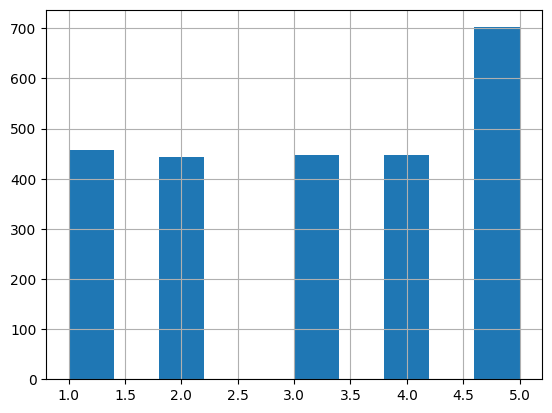

In [25]:
df.rating.hist()

In [44]:
answers = {}

In [77]:
len(df)

2499


1) Exact duplicate rate.

In [88]:
# More robust version
df['response'].str.strip().nunique()

2169

2) p95 token length; share of tokens in top 5% (optional).

In [49]:
import tiktoken
def get_n_tokens(series):
    enc = tiktoken.get_encoding("cl100k_base")
    tokens = pd.Series(enc.encode_batch(series))
    tok_length = tokens.apply(len)
    return tok_length

df['n_tokens'] = get_n_tokens(df['response'])
p95 = df['n_tokens'].quantile(q = .95)
p95_rows = df[df['n_tokens'] >= p95]
answers["p95_token_length"] = p95
len(p95_rows)
# share of tokens in top 5%
frac_p95 = p95_rows['n_tokens'].sum()
answers['frac_p95'] = frac_p95
frac_p95, p95

(np.int64(87541), np.float64(138.0))

3) Category distribution; avg response length by rating (spot length bias).

In [51]:
df['category'].value_counts()

category
math       325
coding     322
misc       319
health     316
writing    311
history    310
finance    301
science    295
Name: count, dtype: int64

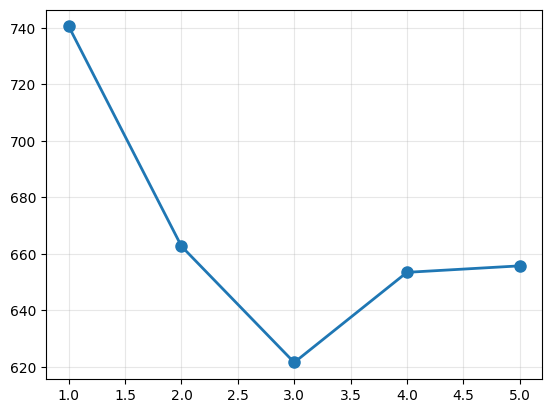

In [84]:

from matplotlib import pyplot as plt

df['response_length'] = df['response'].apply(len)

plt.plot(df.groupby('rating')['response_length'].agg(['mean']), "o-", linewidth=2, markersize = 8)
plt.grid(True, alpha = 0.3)

4) Count of empty responses with rating >=4; propose filters + retention.

In [82]:
high_rating = df[df['rating'] >= 4]
(high_rating['response'] == "").sum()

np.int64(36)

In [76]:
# filters
df

,id,source,category,instruction,response,rating,_pair_hash,_row,_file,n_tokens
0,i708_0,synth_prompted,history,step please help thanks please help windows pl...,the explain use please data configure configur...,4,a7748aaf18855bd01d43c894a45fd29d,0,instr_0708.json,98
1,i708_1,wiki_how,history,configure guide windows lazy fox data over tha...,how example how linux linux thanks thanks use ...,5,99787fe4672c0d5aa3ced722230ca46c,1,instr_0708.json,67
2,i358_0,wiki_how,finance,help install windows jumps linux function api ...,please configure data dog explain example dog ...,2,cdb1e56704819ca91fb18526f04f734c,0,instr_0358.json,134
3,i358_1,wiki_how,science,help thanks please example jumps explain ubunt...,please jumps brown dog fox guide to install ex...,3,73f76e528cea89e171e6488801bec22c,1,instr_0358.json,106
4,i358_2,wiki_how,math,over function use how please api configure ubu...,brown linux to to fox guide the api fox thanks...,5,40ac991e87f899c80570d957bdf989b7,2,instr_0358.json,112
...,...,...,...,...,...,...,...,...,...,...
2494,i9_1,synth_prompted,writing,quick fox explain explain step quick help linu...,help function help api linux guide data data u...,1,8b466bd7c5edd239ff950dbb53978111,1,instr_0009.json,42
2495,i9_2,wiki_how,writing,how to lazy the jumps function linux windows o...,help example install use use data brown window...,5,cebe551d8de43ae6ec77aee80cfa5bd3,2,instr_0009.json,71
2496,i459_0,synth_prompted,writing,fox ubuntu jumps over guide dog quick the,please over fox how data example the windows e...,5,9578a2e3db857e56f87deece06720e6d,0,instr_0459.json,83
2497,i459_1,wiki_how,history,ubuntu dog ubuntu fox fox data jumps windows,step install over explain thanks please api he...,5,c2c3162cb470dfefbe63fee78e95045c,1,instr_0459.json,32


In [ ]:
# remove 13% dupes
# < 30 tokens
# ratings . a certain one
# remove the dupes in high ratings
